<a href="https://colab.research.google.com/github/imabari/covid19-data/blob/master/hyougo/hyougo_yousei_check.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install japanize-matplotlib

In [ ]:
import pathlib
import re
from urllib.parse import urljoin

In [ ]:
import requests
from bs4 import BeautifulSoup

# スクレイピング

In [ ]:
def get_excel(url):

    r = requests.get(url)
    r.raise_for_status()

    soup = BeautifulSoup(r.content, "html.parser")
    tag = soup.find("a", href=re.compile("xls[mx]?$"))

    if tag:
        link = urljoin(url, tag.get("href"))
        p = get_file(link, "data")

        return p
    else:
        raise FileNotFoundError("Excelファイルが見つかりません")

In [ ]:
def get_file(url, dir="."):
    
    r = requests.get(url)
    r.raise_for_status()

    p = pathlib.Path(dir, pathlib.PurePath(url).name)
    p.parent.mkdir(parents=True, exist_ok=True)

    with p.open(mode="wb") as fw:
        fw.write(r.content)
    return p

In [ ]:
import pandas as pd

In [ ]:
p = get_excel("https://web.pref.hyogo.lg.jp/kk03/corona_kanjyajyokyo.html")

df_kanja = pd.read_excel(
    p,
    skiprows=3,
    skipfooter=2,
    usecols=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    dtype={"番号": "Int64"},
)

In [ ]:
df_kanja.shape

(1426, 10)

In [ ]:
df_kanja.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1426 entries, 0 to 1425
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   番号      1424 non-null   Int64 
 1   発表日     1424 non-null   object
 2   年代      1424 non-null   object
 3   性別      1424 non-null   object
 4   管轄      1424 non-null   object
 5   居住地     1424 non-null   object
 6   職業      1423 non-null   object
 7   発症日     1424 non-null   object
 8   渡航歴     1424 non-null   object
 9   備考欄     1423 non-null   object
dtypes: Int64(1), object(9)
memory usage: 112.9+ KB


In [ ]:
df_kanja.count()

番号     1424
発表日    1424
年代     1424
性別     1424
管轄     1424
居住地    1424
職業     1423
発症日    1424
渡航歴    1424
備考欄    1423
dtype: int64

# 前処理

In [ ]:
import matplotlib.pyplot as plt
import japanize_matplotlib

In [ ]:
# 解像度
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200

In [ ]:
# 除外
df_kanja.set_index("番号", inplace=True)
df_kanja = df_kanja.drop(738)

In [ ]:
# 全列欠損を削除

df_kanja.dropna(how="all", inplace=True)

In [ ]:
# 備考欄

df_kanja["備考欄"] = df_kanja["備考欄"].str.replace("\n", "")
df_kanja["備考欄"] = df_kanja["備考欄"].str.replace("NO.|N0.|NO,|N0,|No,", "No.")
df_kanja["備考欄"] = df_kanja["備考欄"].str.replace("・", "、")
df_kanja["備考欄"] = df_kanja["備考欄"].fillna("")

In [ ]:
# 発表日

flg_is_serial = df_kanja["発表日"].astype("str").str.isdigit()

fromSerial = pd.to_datetime(
    df_kanja.loc[flg_is_serial, "発表日"].astype(float),
    unit="D",
    origin=pd.Timestamp("1899/12/30"),
)
fromString = pd.to_datetime(df_kanja.loc[~flg_is_serial, "発表日"])

df_kanja["発表日"] = pd.concat([fromString, fromSerial])

In [ ]:
# ステータス

df_kanja["ステータス"] = df_kanja["発症日"].mask(df_kanja["発症日"].astype("str").str.isdigit(), "症状あり")

In [ ]:
# 発症日

df_kanja["発症日"] = df_kanja["発症日"].where(df_kanja["発症日"].astype("str").str.isdigit())
df_kanja["発症日"] = pd.to_datetime(df_kanja["発症日"].astype(float), unit="D", origin=pd.Timestamp("1899/12/30"))

# 年代確認

## 年代別グラフ

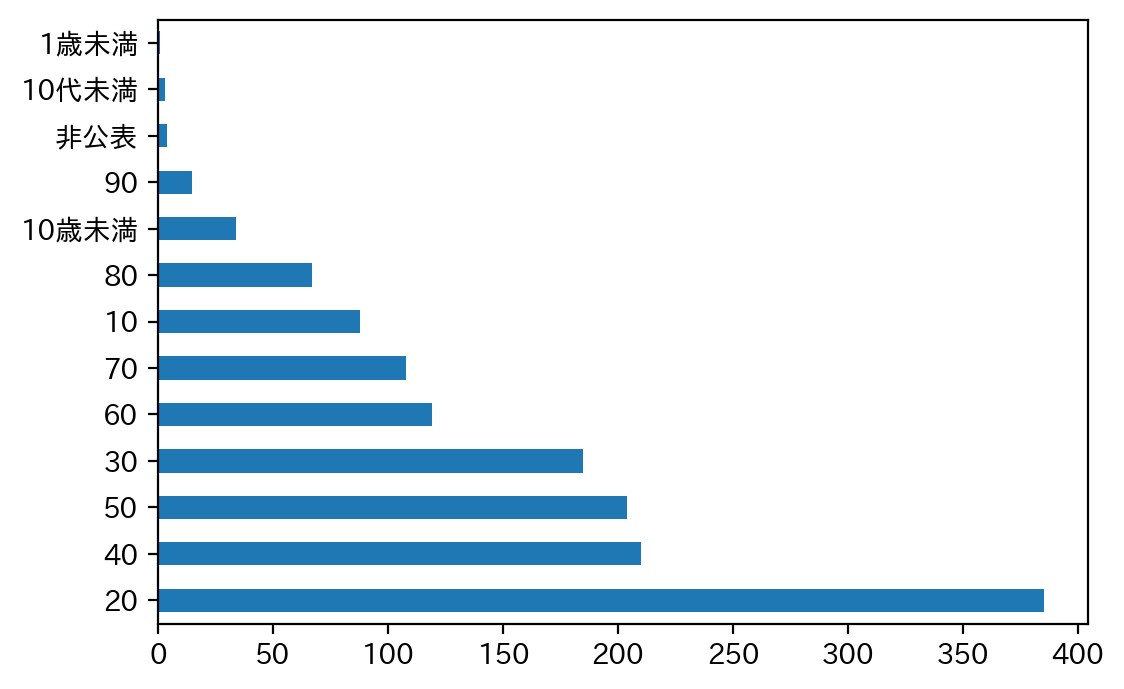

In [ ]:
df_kanja["年代"].value_counts().plot.barh()

## 年代別一覧

In [ ]:
df_kanja["年代"].value_counts()

20       385
40       210
50       204
30       185
60       119
70       108
10        88
80        67
10歳未満     34
90        15
非公表        4
10代未満      3
1歳未満       1
Name: 年代, dtype: int64

In [ ]:
df_kanja[df_kanja["年代"] == "10代未満"]

,発表日,年代,性別,管轄,居住地,職業,発症日,渡航歴,備考欄,ステータス
番号,,,,,,,,,,
401,2020-04-14,10代未満,女性,伊丹,伊丹健康福祉事務所管内,幼児,NaT,なし,No.348の濃厚接触者,症状なし
386,2020-04-14,10代未満,男性,神戸,神戸市,非公表,2020-04-11,なし,感染患者と接触あり,症状あり
385,2020-04-14,10代未満,男性,神戸,神戸市,非公表,2020-04-11,なし,感染患者と接触あり,症状あり


# 性別確認

## 性別別グラフ

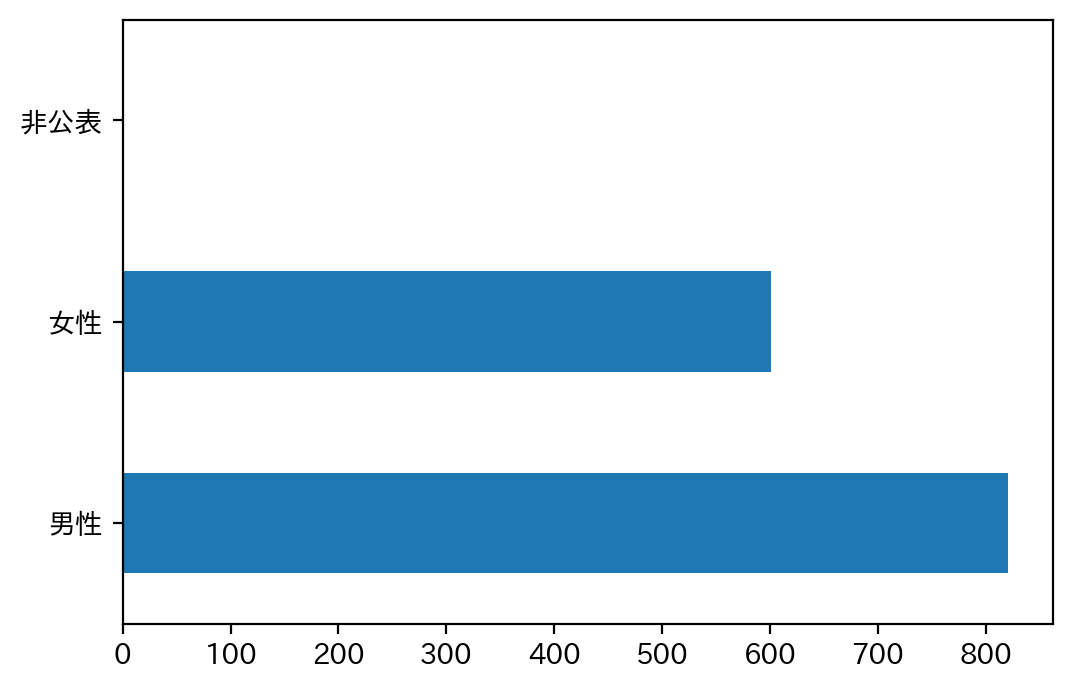

In [ ]:
df_kanja["性別"].value_counts().plot.barh()

## 性別別一覧

In [ ]:
df_kanja["性別"].value_counts()

男性     821
女性     601
非公表      1
Name: 性別, dtype: int64

# 居住地確認

## 居住地別グラフ

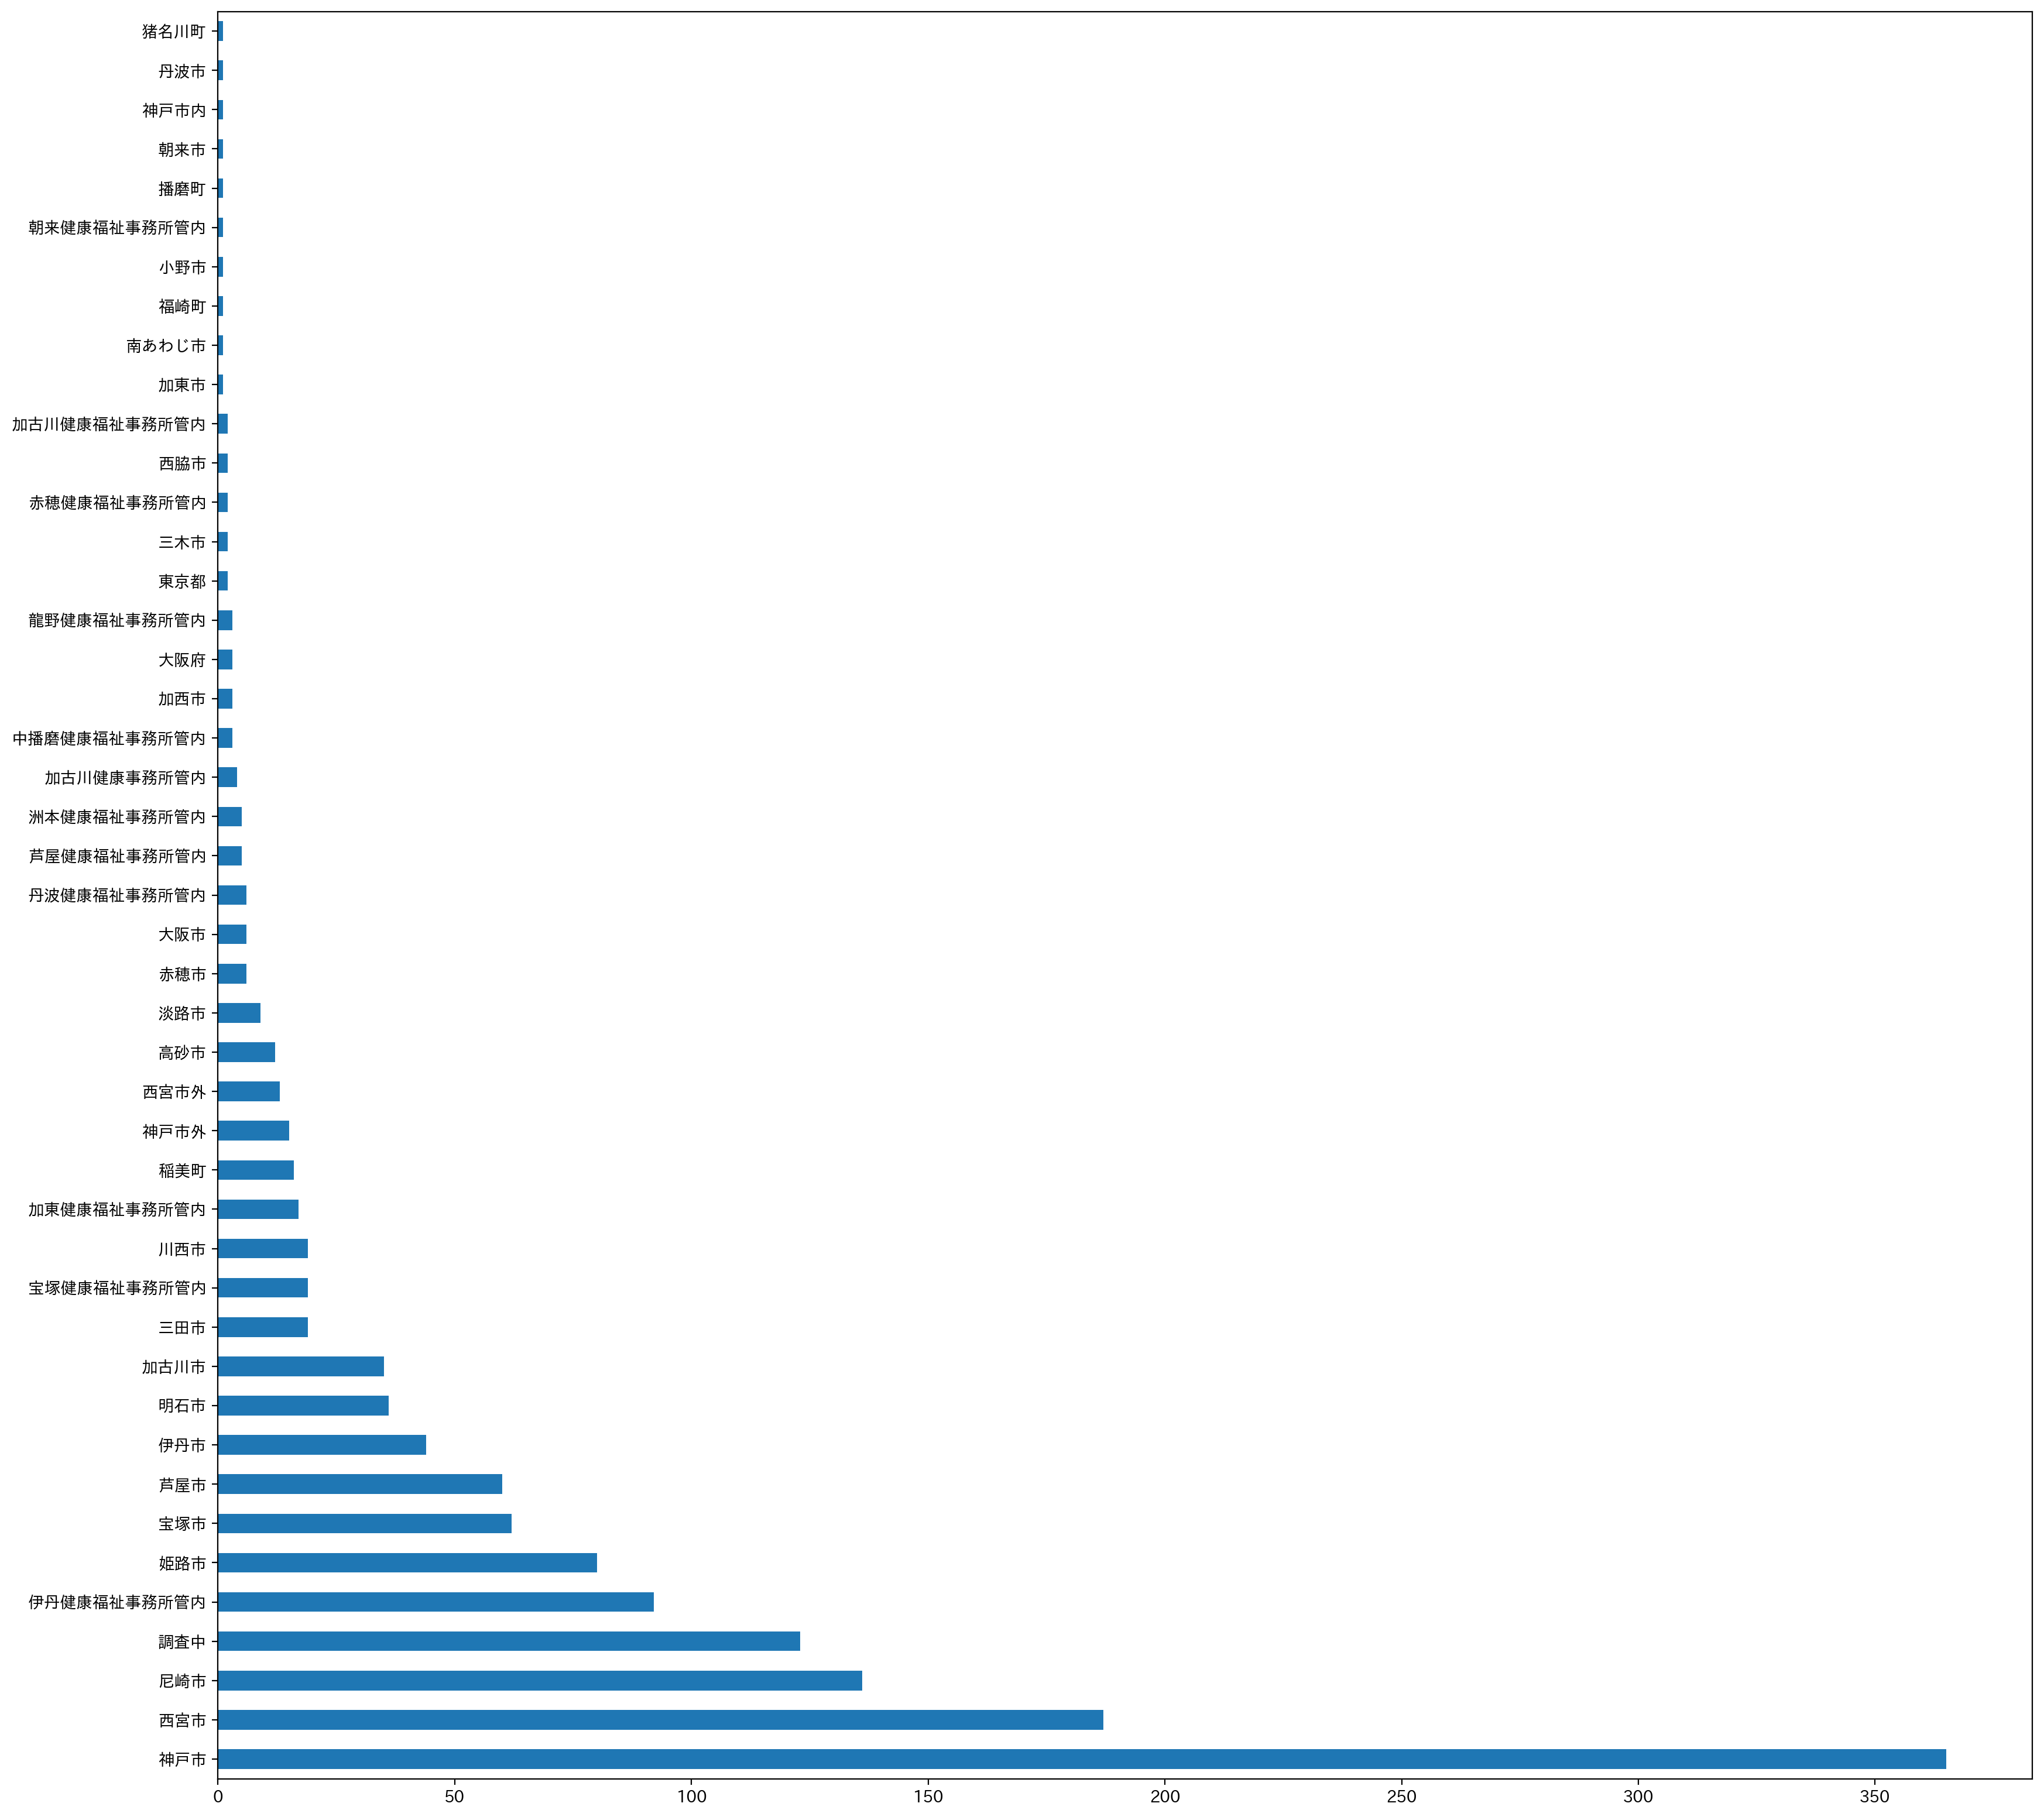

In [ ]:
df_kanja["居住地"].value_counts().plot.barh(figsize=(20, 20))

## 居住地別一覧

In [ ]:
df_kanja["居住地"].value_counts()

神戸市             365
西宮市             187
尼崎市             136
調査中             123
伊丹健康福祉事務所管内      92
姫路市              80
宝塚市              62
芦屋市              60
伊丹市              44
明石市              36
加古川市             35
三田市              19
宝塚健康福祉事務所管内      19
川西市              19
加東健康福祉事務所管内      17
稲美町              16
神戸市外             15
西宮市外             13
高砂市              12
淡路市               9
赤穂市               6
大阪市               6
丹波健康福祉事務所管内       6
芦屋健康福祉事務所管内       5
洲本健康福祉事務所管内       5
加古川健康事務所管内        4
中播磨健康福祉事務所管内      3
加西市               3
大阪府               3
龍野健康福祉事務所管内       3
東京都               2
三木市               2
赤穂健康福祉事務所管内       2
西脇市               2
加古川健康福祉事務所管内      2
加東市               1
南あわじ市             1
福崎町               1
小野市               1
朝来健康福祉事務所管内       1
播磨町               1
朝来市               1
神戸市内              1
丹波市               1
猪名川町              1
Name: 居住地, dtype: int64

# 職業確認

## 職業別グラフ

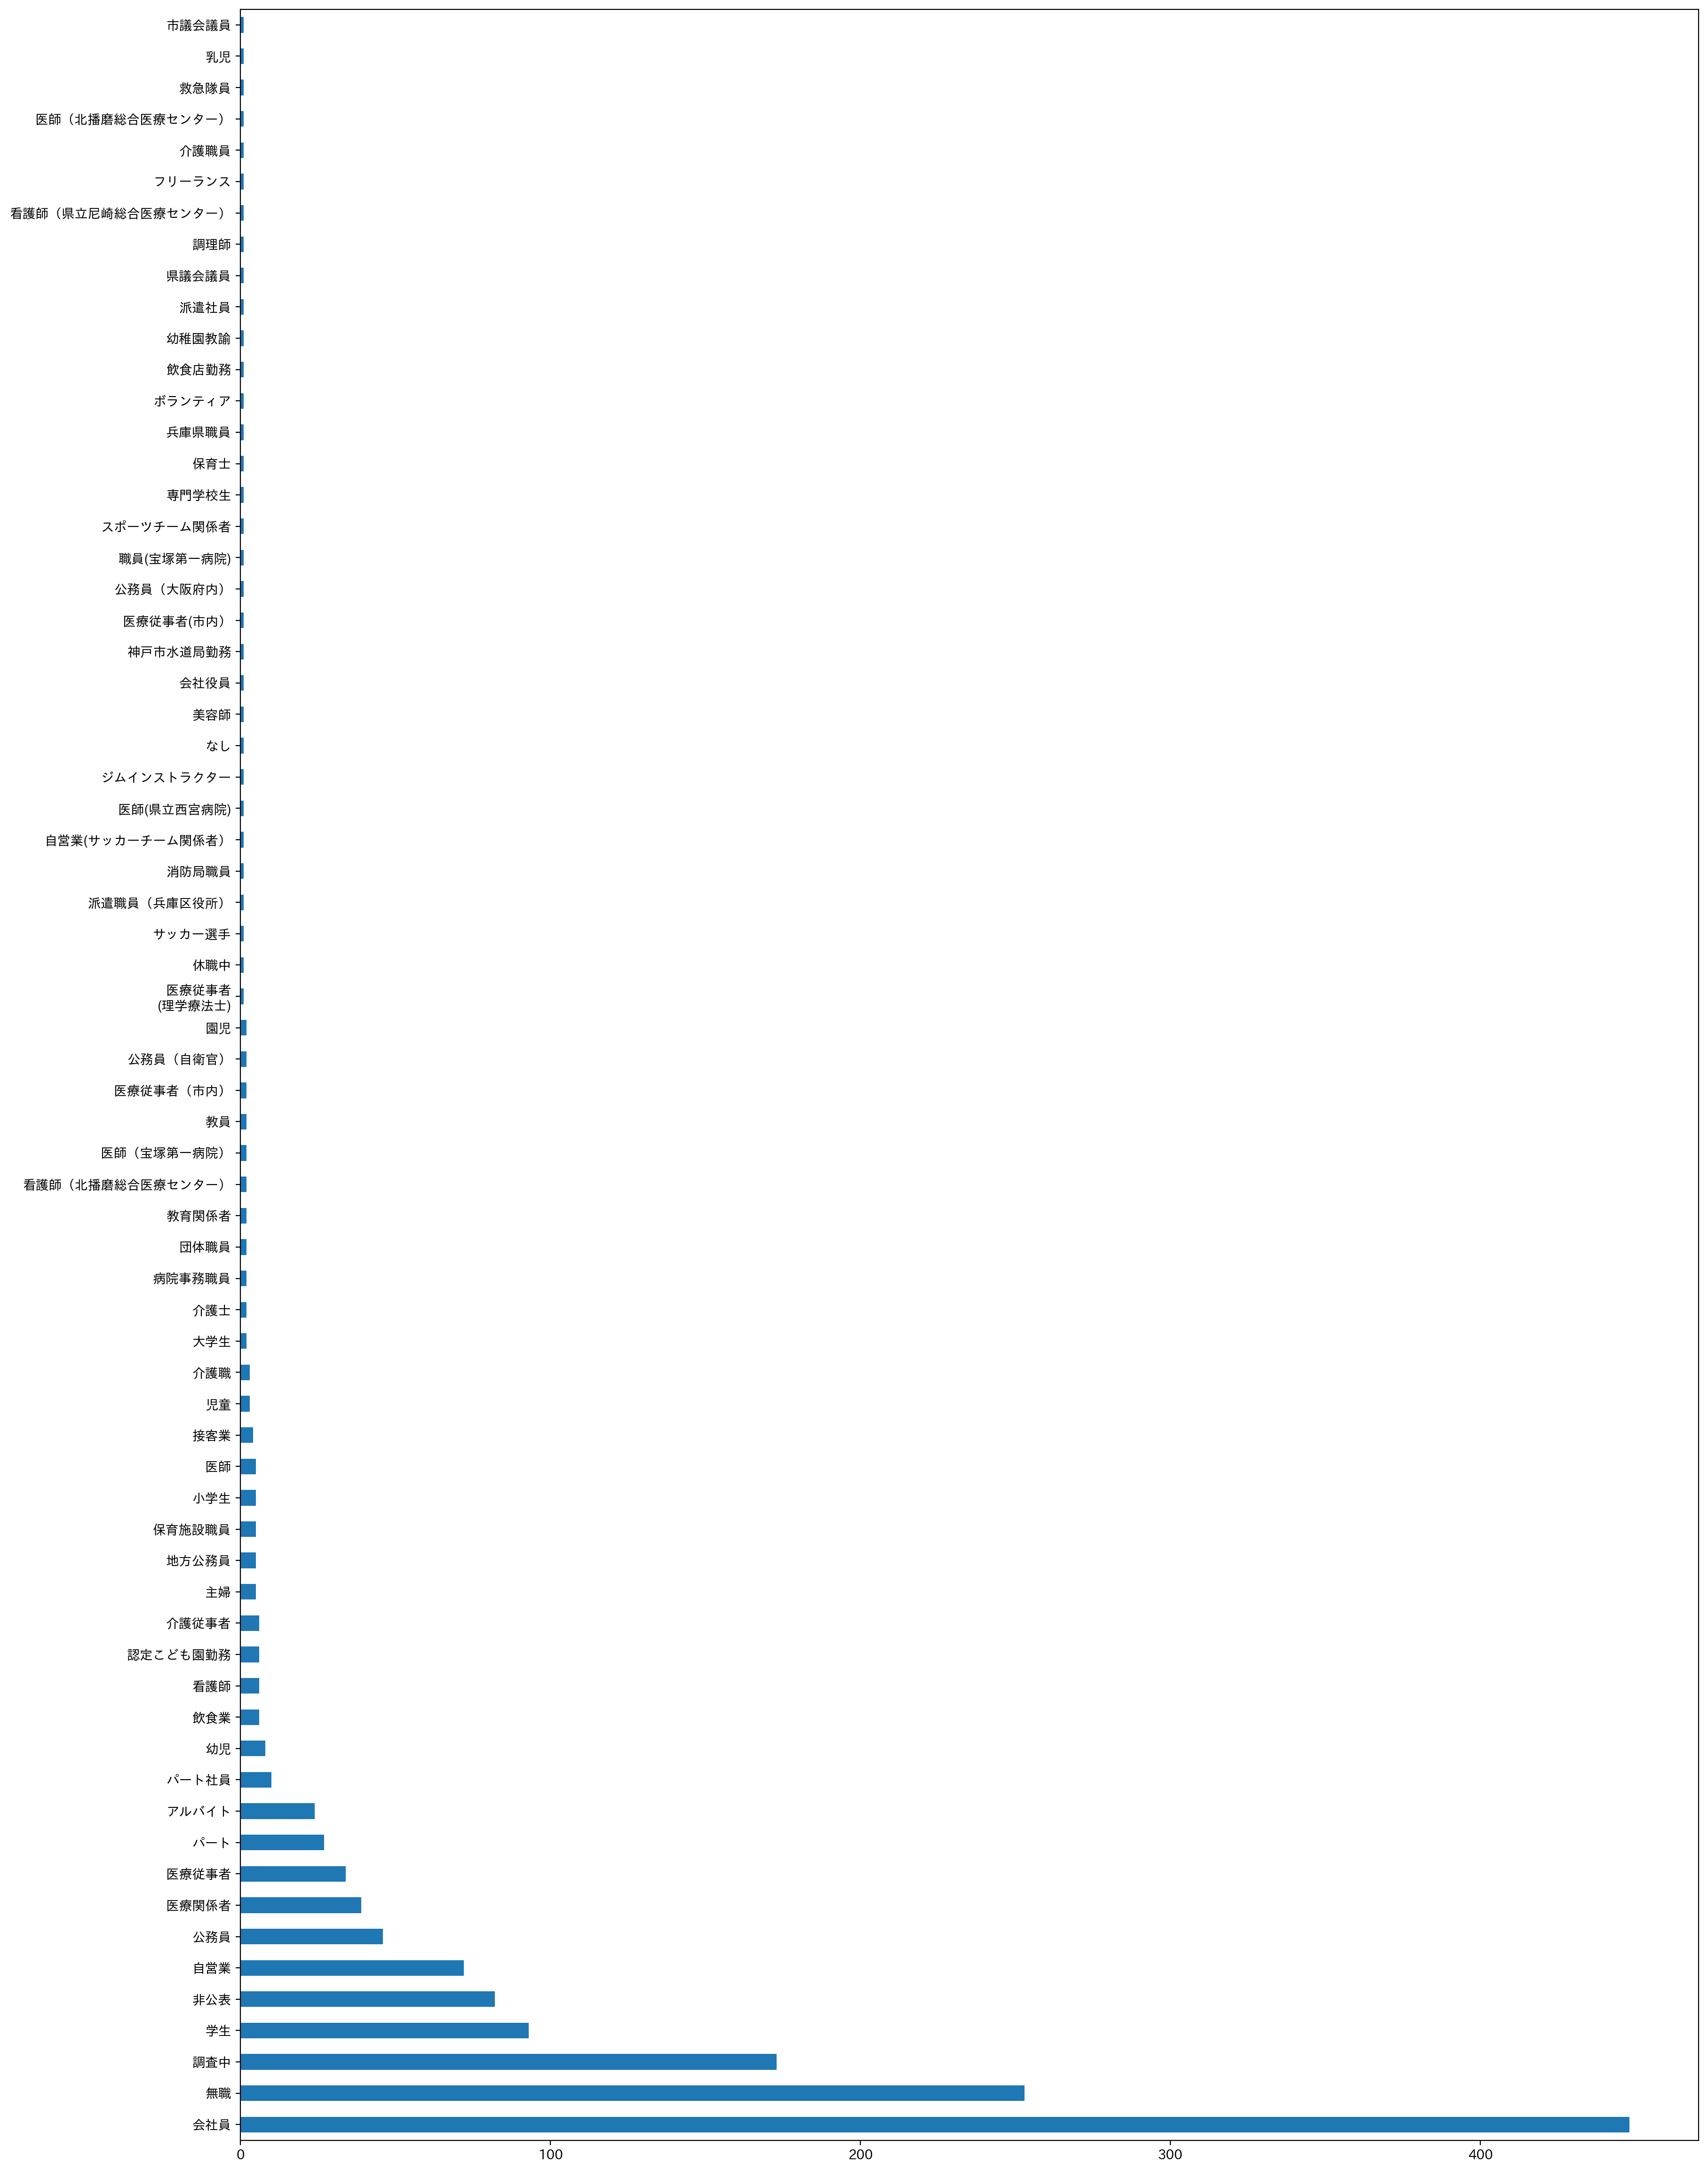

In [ ]:
df_kanja["職業"].value_counts().plot.barh(figsize=(20, 30))

## 職業別一覧

In [ ]:
df_kanja["職業"].value_counts()

会社員                448
無職                 253
調査中                173
学生                  93
非公表                 82
                  ... 
介護職員                 1
医師（北播磨総合医療センター）      1
救急隊員                 1
乳児                   1
市議会議員                1
Name: 職業, Length: 68, dtype: int64

# 管轄確認

## 管轄別グラフ

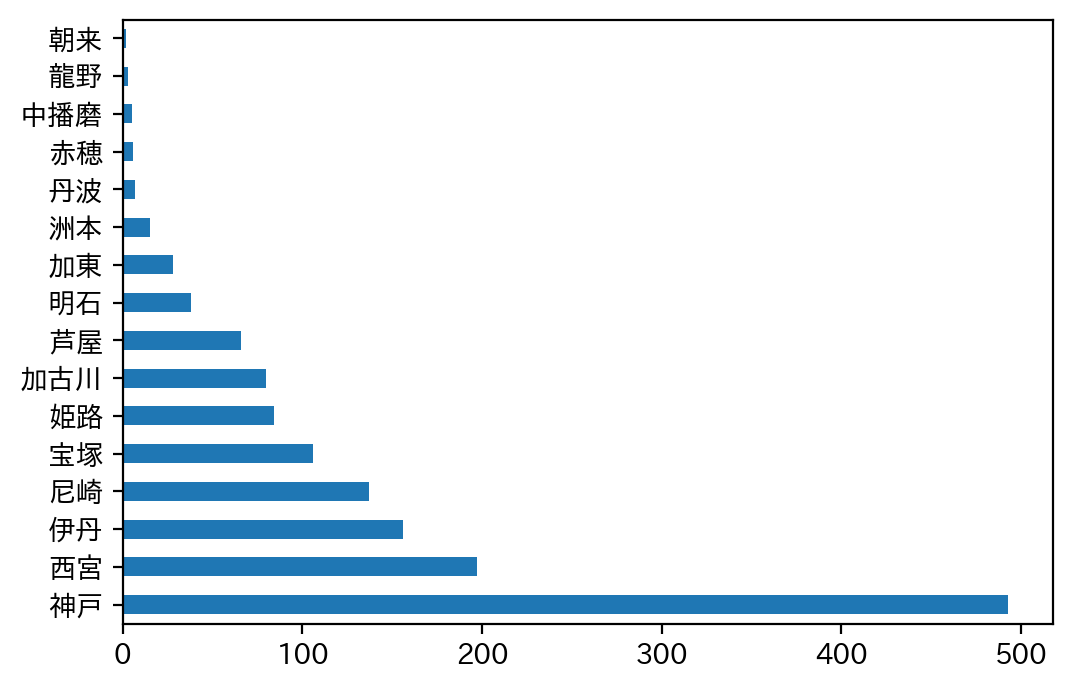

In [ ]:
df_kanja["管轄"].value_counts().plot.barh()

## 管轄別一覧

In [ ]:
df_kanja["管轄"].value_counts()

神戸     493
西宮     197
伊丹     156
尼崎     137
宝塚     106
姫路      84
加古川     80
芦屋      66
明石      38
加東      28
洲本      15
丹波       7
赤穂       6
中播磨      5
龍野       3
朝来       2
Name: 管轄, dtype: int64

# 渡航歴確認

## 渡航歴別グラフ

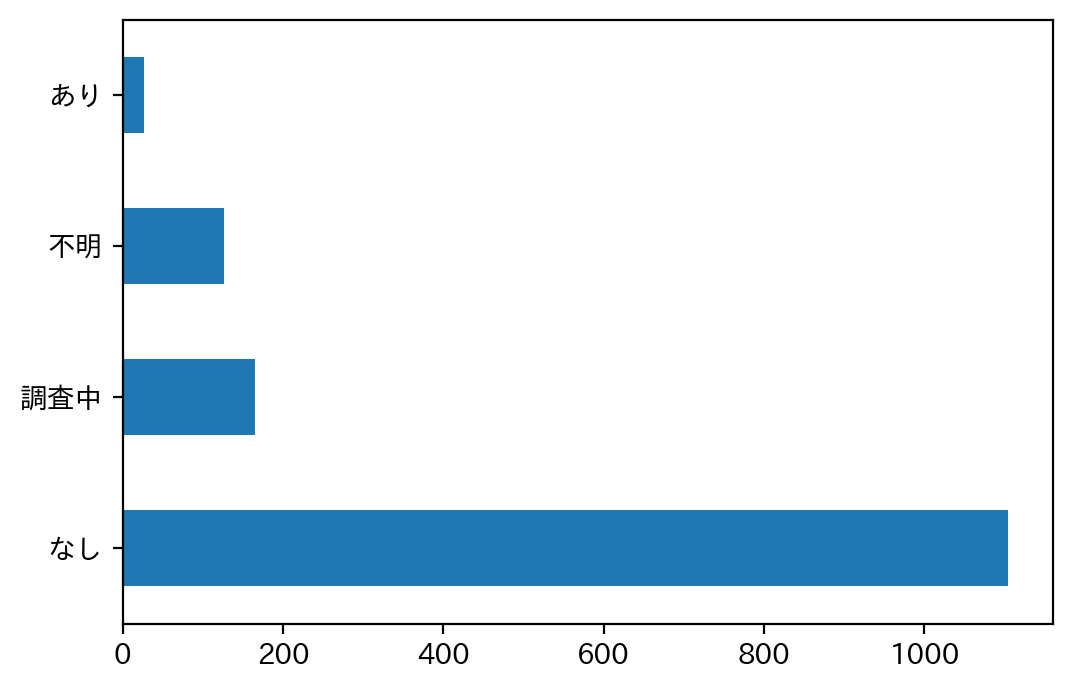

In [ ]:
df_kanja["渡航歴"].value_counts().plot.barh()

## 渡航歴別一覧

In [ ]:
df_kanja["渡航歴"].value_counts()

なし     1105
調査中     165
不明      127
あり       26
Name: 渡航歴, dtype: int64

# ステータス確認

## ステータス別グラフ

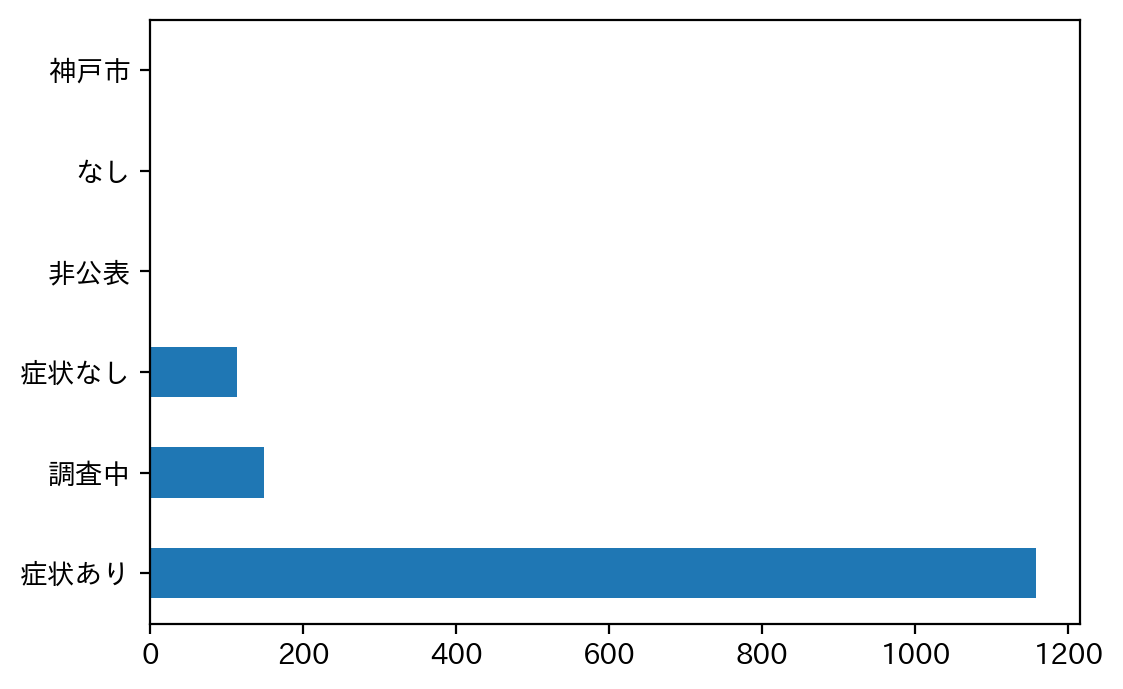

In [ ]:
df_kanja["ステータス"].value_counts().plot.barh()

## ステータス別一覧

In [ ]:
df_kanja["ステータス"].value_counts()

症状あり    1158
調査中      149
症状なし     113
非公表        1
なし         1
神戸市        1
Name: ステータス, dtype: int64

# 全体確認

In [ ]:
df_kanja

,発表日,年代,性別,管轄,居住地,職業,発症日,渡航歴,備考欄,ステータス
番号,,,,,,,,,,
1424,2020-08-05,50,男性,洲本,洲本健康福祉事務所管内,自営業,2020-07-28,なし,行動歴調査中,症状あり
1423,2020-08-05,70,男性,朝来,朝来市,非公表,2020-07-24,なし,行動歴調査中,症状あり
1422,2020-08-05,30,男性,加東,小野市,無職,2020-07-27,なし,行動歴調査中,症状あり
1421,2020-08-05,40,男性,加古川,高砂市,会社員,2020-07-30,なし,行動歴調査中,症状あり
1420,2020-08-05,70,男性,加古川,加古川市,非公表,2020-07-31,なし,陽性患者の濃厚接触者,症状あり
...,...,...,...,...,...,...,...,...,...,...
5,2020-03-06,40,男性,姫路,姫路市,会社員,2020-02-23,なし,2/19に大阪のSoap operaライブに参加,症状あり
4,2020-03-05,50,女性,中播磨,福崎町,無職,2020-02-22,なし,2/15、16に大阪のライブハウスArcに参加,症状あり
3,2020-03-03,40,女性,神戸,神戸市,会社員,2020-02-21,なし,2/15、16に大阪のライブハウスArcに参加,症状あり


# ファイル保存

In [ ]:
import datetime

JST = datetime.timezone(datetime.timedelta(hours=+9))

dt_now = datetime.datetime.now(JST).date().isoformat()

## 全体

In [ ]:
df_kanja.to_csv("kanja.tsv", sep="\t")

## 年齢別抽出

In [ ]:
# 年齢別抽出

grouped_df = df_kanja.groupby("年代")

with pd.ExcelWriter(f"陽性者一覧（年齢別）_{dt_now}.xlsx", engine="openpyxl") as writer:

    for id in grouped_df.groups:

        d = grouped_df.get_group(id)

        # ExcelWriterを用いて新規シートにDataFrameを保存
        d.to_excel(writer, sheet_name=str(id), index=False)

# ダウンロード

In [ ]:
from google.colab import files

In [ ]:
files.download(f"陽性者一覧（年齢別）_{dt_now}.xlsx")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# PCR

In [ ]:
df_pcr = pd.read_excel("https://web.pref.hyogo.lg.jp/kk03/documents/pcr.xlsx", index_col="年月日").fillna(0).astype(int)

In [ ]:
df_pcr.rename(
    columns={
        "検査件数（合計）": "合計検査件数",
        "うち地方衛生研究所等によるPCR検査件数": "地方PCR検査件数",
        "うち民間検査機関等によるPCR検査件数": "民間PCR検査件数",
        "うち民間検査機関等による抗原検査件数": "民間抗原検査件数",
    },
    inplace=True,
)

In [ ]:
df_pcr

,合計検査件数,地方PCR検査件数,民間PCR検査件数,民間抗原検査件数,陽性件数
年月日,,,,,
2020-01-31,2,2,0,0,0
2020-02-01,0,0,0,0,0
2020-02-02,0,0,0,0,0
2020-02-03,1,1,0,0,0
2020-02-04,0,0,0,0,0
...,...,...,...,...,...
2020-08-01,650,331,271,48,32
2020-08-02,530,186,318,26,60
2020-08-03,434,132,263,39,27


In [ ]:
df_pcr.to_csv("pcr.tsv", sep="\t")

# 陽性者

In [ ]:
df_yousei = pd.read_excel("https://web.pref.hyogo.lg.jp/kk03/documents/yousei.xlsx", index_col="発表年月日")

In [ ]:
df_yousei.columns

Index(['発表時間', '検査実施人数（累計）　　', '陽性者数（累計）　', '入院中（合計）', '入院中（中等症以下）', '入院中（重症）',
       '宿泊療養', '死亡（累計）', '退院（累計）'],
      dtype='object')

In [ ]:
df_yousei.columns = df_yousei.columns.map(lambda s: s.replace("（累計）", "").strip())

In [ ]:
df_yousei.drop("発表時間", axis=1, inplace=True)

In [ ]:
df_yousei = df_yousei.fillna(0).astype(int)

In [ ]:
df_yousei.to_csv("yousei.tsv", sep="\t")

In [ ]:
ser = df_kanja["発表日"].value_counts().sort_index().asfreq("D").fillna(0)

In [ ]:
df = df_pcr.cumsum().join(df_yousei).join(ser.cumsum()).fillna(0).astype(int)

In [ ]:
df.to_csv("all.tsv", sep="\t")

# チェック

## kanjya.xlsx

### 年代

In [ ]:
df_kanja[~df_kanja["年代"].isin(["10歳未満", 10, 20, 30, 40, 50, 60, 70, 80, 90, "非公表"])]

,発表日,年代,性別,管轄,居住地,職業,発症日,渡航歴,備考欄,ステータス
番号,,,,,,,,,,
637,2020-04-28,1歳未満,男性,伊丹,川西市,乳児,2020-04-15,なし,No.635の子,症状あり
401,2020-04-14,10代未満,女性,伊丹,伊丹健康福祉事務所管内,幼児,NaT,なし,No.348の濃厚接触者,症状なし
386,2020-04-14,10代未満,男性,神戸,神戸市,非公表,2020-04-11,なし,感染患者と接触あり,症状あり
385,2020-04-14,10代未満,男性,神戸,神戸市,非公表,2020-04-11,なし,感染患者と接触あり,症状あり


### 居住地

In [ ]:
nlist = df_kanja.loc[~df_kanja["居住地"].str.endswith(("都", "道", "府", "県", "市", "区", "町", "村", "市内", "市外", "事務所管内")) & ~(df_kanja["居住地"] == "調査中"), "居住地"].unique()
df_kanja[df_kanja["居住地"].isin(nlist)]

,発表日,年代,性別,管轄,居住地,職業,発症日,渡航歴,備考欄,ステータス
番号,,,,,,,,,,


### ステータス

発症日の日付以外のデータをコピー

In [ ]:
df_kanja[~df_kanja["ステータス"].isin(["症状あり", "症状なし", "調査中", "非公表"])]

,発表日,年代,性別,管轄,居住地,職業,発症日,渡航歴,備考欄,ステータス
番号,,,,,,,,,,
931,2020-07-24,30,女性,尼崎,尼崎市,無職,NaT,なし,No926の濃厚接触者 No926，932の同居人,なし
751,2020-07-15,10,女性,神戸,神戸市,学生,NaT,なし,垂水中学校の生徒,神戸市


### 渡航歴

In [ ]:
df_kanja[~df_kanja["渡航歴"].isin(["あり", "なし", "調査中", "不明"])]

,発表日,年代,性別,管轄,居住地,職業,発症日,渡航歴,備考欄,ステータス
番号,,,,,,,,,,


## pcr.xlsx

### 検査件数集計

In [ ]:
df_pcr[df_pcr["合計検査件数"] != df_pcr["地方PCR検査件数"] + df_pcr["民間PCR検査件数"] + df_pcr["民間抗原検査件数"]]

,合計検査件数,地方PCR検査件数,民間PCR検査件数,民間抗原検査件数,陽性件数
年月日,,,,,


## yousei.xlsx

### 入院中集計

In [ ]:
df_yousei[df_yousei["入院中（合計）"] != df_yousei["入院中（中等症以下）"] + df_yousei["入院中（重症）"]]

,検査実施人数,陽性者数,入院中（合計）,入院中（中等症以下）,入院中（重症）,宿泊療養,死亡,退院
発表年月日,,,,,,,,


### 陽性者数集計

In [ ]:
df_yousei[df_yousei["陽性者数"] != df_yousei["入院中（合計）"] + df_yousei["宿泊療養"] +  df_yousei["死亡"] + df_yousei["退院"]]

,検査実施人数,陽性者数,入院中（合計）,入院中（中等症以下）,入院中（重症）,宿泊療養,死亡,退院
発表年月日,,,,,,,,


### 累計前日差チェック

In [269]:
yousei_diff = df_yousei[["検査実施人数", "陽性者数", "死亡", "退院"]].diff().fillna(0).astype(int)

In [271]:
yousei_diff[yousei_diff < 0].dropna(how='all')

,検査実施人数,陽性者数,死亡,退院
発表年月日,,,,
2020-06-29,NaN,NaN,NaN,-2.0


## pcr.xlsxとyousei.xlsx

### 陽性者数

3/9まで「yousei.xlsx」データなし

In [ ]:
df.loc[df["陽性件数"] != df["陽性者数"], ["陽性件数", "陽性者数"]]

,陽性件数,陽性者数
年月日,,
2020-03-01,1,0
2020-03-02,1,0
2020-03-03,3,0
2020-03-04,3,0
2020-03-05,4,0
2020-03-06,8,0
2020-03-07,10,0
2020-03-08,12,0
2020-03-09,16,0


### 検査件数

3/9まで「yousei.xlsx」データなし

In [ ]:
df.loc[df["合計検査件数"] != df["検査実施人数"], ["合計検査件数", "検査実施人数"]]

,合計検査件数,検査実施人数
年月日,,
2020-01-31,2,0
2020-02-01,2,0
2020-02-02,2,0
2020-02-03,3,0
2020-02-04,3,0
2020-02-05,3,0
2020-02-06,4,0
2020-02-07,4,0
2020-02-08,4,0


## pcr.xlsxとkanjya.xlsx

### 陽性者数

In [ ]:
df.loc[df["陽性件数"] != df["発表日"], ["陽性件数", "発表日"]]

,陽性件数,発表日
年月日,,
